### https://towardsdatascience.com/deep-convolutional-gan-how-to-use-a-dcgan-to-generate-images-in-python-b08afd4d124e

In [ ]:
# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization
from PIL import Image

# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for scaling inputs used in the generator and discriminator


# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version


# Other utilities
import sys
import os
import glob
import zipfile

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

Tensorflow/Keras: 2.12.0
numpy: 1.22.4
sklearn: 1.2.2
OpenCV: 4.7.0
matplotlib: 3.7.1
graphviz: 0.20.1


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Mount Google Drive to Colab
# from google.colab import drive
# drive.mount('/content/drive')

# Set the file ID of the zip file
file_id = '1KZo4q3AEUygoxChOAKRmyaEbY4-Amy-2'

# Set the destination path for the zip file
destination = '/content/ikea-master.zip'

# Download the file from Google Drive
!gdown --id $file_id -O $destination

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1KZo4q3AEUygoxChOAKRmyaEbY4-Amy-2
To: /content/ikea-master.zip
100% 94.6M/94.6M [00:00<00:00, 153MB/s]


In [ ]:
# Extract zip file
with zipfile.ZipFile("/content/ikea-master.zip","r") as zip_ref:
    zip_ref.extractall("/content/ikea_master_dataset")

In [ ]:
img_shape = 128

In [ ]:
path  = '/content/ikea_master_dataset/ikea-master/images/room_scenes/*.jpg'
filelist = glob.glob(path)

x_train = (np.array([np.array(Image.open(fname).resize((img_shape,img_shape))) for fname in filelist]).astype('float'))/255.0
x_train.shape

(215, 128, 128, 3)

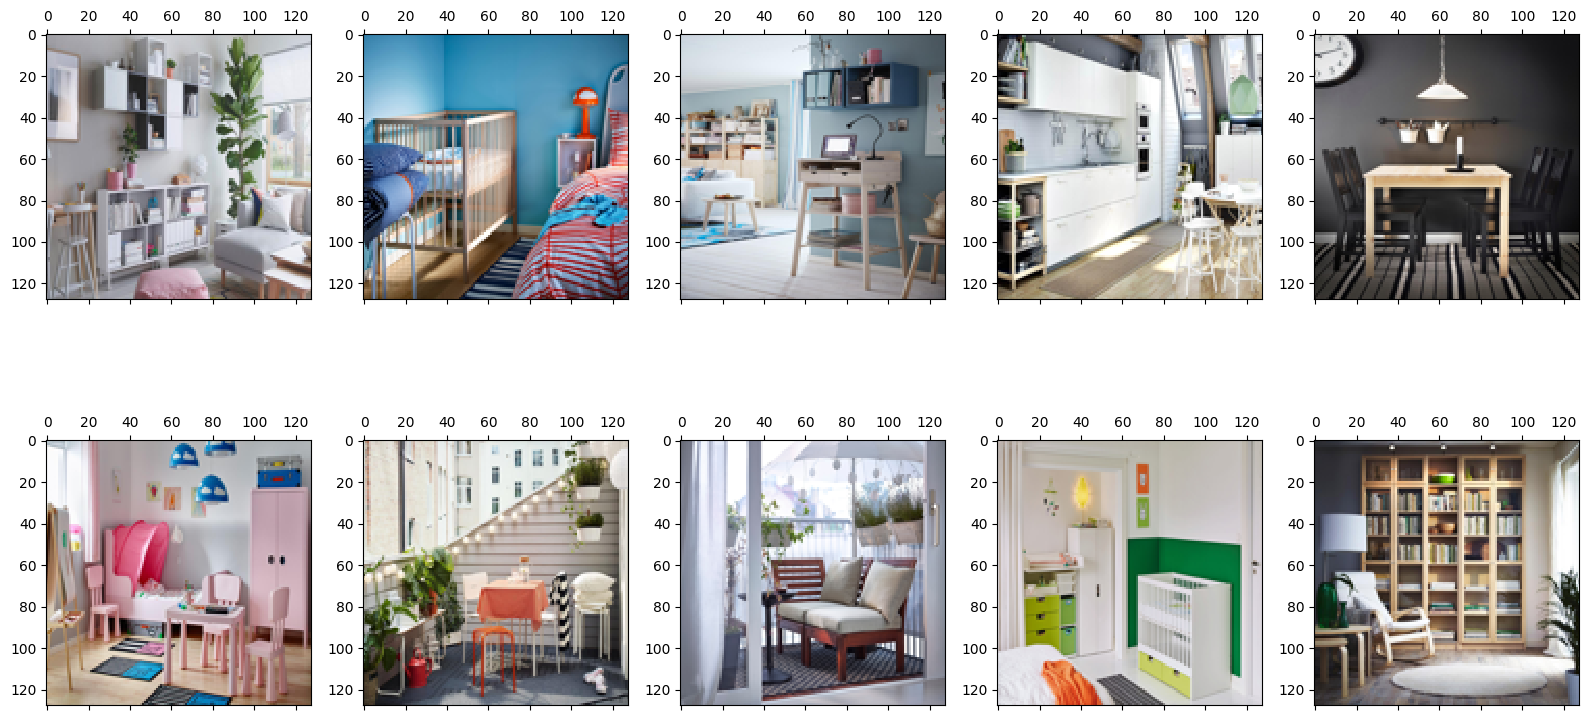

In [ ]:
# Display 10 real images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(x_train[n])
        n=n+1
plt.show()

In [ ]:
# Scaler
scaler=MinMaxScaler(feature_range=(-1, 1))

# Select images that we want to use for model trainng
data=x_train.copy()
print("Original shape of the data: ", data.shape)

# Reshape array
data=data.reshape(-1, 1)
print("Reshaped data: ", data.shape)

# Fit the scaler
scaler.fit(data)

# Scale the array
data=scaler.transform(data)

# Reshape back to the original shape
data=data.reshape(x_train.shape[0], img_shape, img_shape, 3)
print("Shape of the scaled array: ", data.shape)

Original shape of the data:  (215, 128, 128, 3)
Reshaped data:  (10567680, 1)
Shape of the scaled array:  (215, 128, 128, 3)


Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (D  (None, 8192)             827392    
 ense)                                                           
                                                                 
 Generator-Hidden-Layer-Resh  (None, 8, 8, 128)        0         
 ape-1 (Reshape)                                                 
                                                                 
 Generator-Hidden-Layer-2 (C  (None, 16, 16, 128)      262272    
 onv2DTranspose)                                                 
                                                                 
 Generator-Hidden-Layer-Acti  (None, 16, 16, 128)      0         
 vation-2 (ReLU)                                                 
                                                                 
 Generator-Hidden-Layer-3 (C  (None, 32, 32, 256)      52

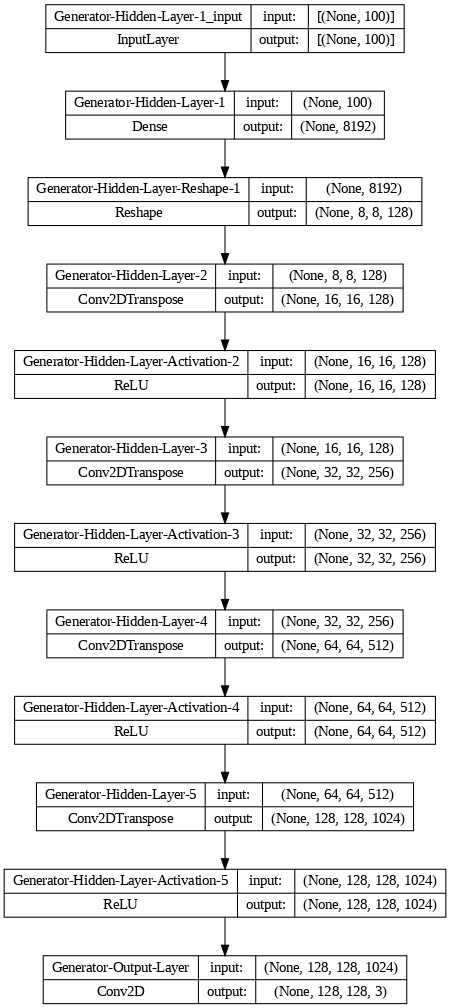

In [ ]:
def generator(latent_dim):
    model = Sequential(name="Generator") # Model

    # Hidden Layer 1: Start with 8 x 8 image
    n_nodes = 8 * 8 * 128 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_dim=latent_dim, name='Generator-Hidden-Layer-1'))
    model.add(Reshape((8, 8, 128), name='Generator-Hidden-Layer-Reshape-1'))

    # Hidden Layer 2: Upsample to 16 x 16
    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-2'))

    # Hidden Layer 3: Upsample to 32 x 32
    model.add(Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-3'))

    # Hidden Layer 4: Upsample to 64 x 64
    model.add(Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-4'))

    # Hidden Layer 5: Upsample to 128 x 128
    model.add(Conv2DTranspose(filters=1024, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-5'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-5'))

    # # Hidden Layer 6: Upsample to 256 x 256
    # model.add(Conv2DTranspose(filters=2048, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-6'))
    # model.add(ReLU(name='Generator-Hidden-Layer-Activation-6'))

    # Output Layer (Note, we use 3 filters because we have 3 channels for a color image. Grayscale would have only 1 channel)
    model.add(Conv2D(filters=3, kernel_size=(5,5), activation='tanh', padding='same', name='Generator-Output-Layer'))
    return model

# Instantiate
latent_dim=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=75)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer-  (None, 64, 64, 128)      6272      
 1 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 64, 64, 128)      0         
 Activation-1 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 32, 32, 256)      524544    
 2 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 32, 32, 256)      0         
 Activation-2 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 16, 16, 256)    

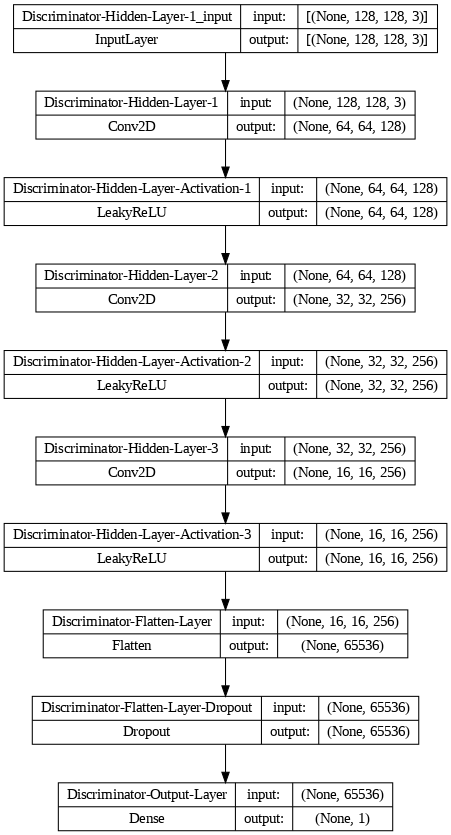

In [ ]:
def discriminator(in_shape=(img_shape,img_shape,3)):
    model = Sequential(name="Discriminator") # Model

    # Hidden Layer 1
    model.add(Conv2D(filters=img_shape, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))

    # Hidden Layer 2
    model.add(Conv2D(filters=img_shape*2, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))

    # Hidden Layer 3
    model.add(Conv2D(filters=img_shape*2, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))

    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=75)

Model: "DCGAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 128, 128, 3)       12178307  
                                                                 
 Discriminator (Sequential)  (None, 1)                 1645185   
                                                                 
Total params: 13,823,492
Trainable params: 13,823,492
Non-trainable params: 0
_________________________________________________________________


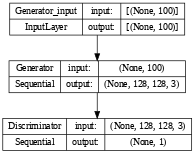

In [ ]:
def def_gan(generator, discriminator):

    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = True

    # Combine
    model = Sequential(name="DCGAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Disriminator

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=50)

In [ ]:
def real_samples(n, dataset):

    # Samples of real data
    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))
    return X, y


def latent_vector(latent_dim, n):

    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)

    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input


def fake_samples(generator, latent_dim, n):

    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)

    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)

    # Create class labels
    y = np.zeros((n, 1))
    return X, y

In [ ]:
def performance_summary(generator, discriminator, dataset, latent_dim, epoch_num, n=50):

    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)

    file_nm = "Performance_image_at_epoch_" + str(epoch_num) + ".png"

    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)

    # summarize discriminator performance
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)

    # Display 6 fake images
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, img_shape, img_shape, 3)

    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,3):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show()
    # fig.savefig("/content/gdrive/MyDrive/Capstone Project/Model/DCGAN_Checkpoints/training_DCGAN_2/Backup/05/" + file_nm)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=32, n_eval=1):

    checkpoint_path = "/content/gdrive/MyDrive/Capstone Project/Model/DCGAN_Checkpoints/training_DCGAN_2/"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator=g_model,discriminator=d_model,GAN = gan_model)

    ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
    if ckpt_manager.latest_checkpoint:
        checkpoint.restore(ckpt_manager.latest_checkpoint)
        print ('Latest checkpoint restored!!')

    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)

    # We will manually enumare epochs
    for i in range(n_epochs):

    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)

        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)

    # Generator training
        # Get values from the latent space to be used as inputs for the generator
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples,
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))

        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)

        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            ckpt_manager.save()
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim,i)

### Change figsave filename in performance summary before run. Change folder name to next folder number

In [ ]:
# Train DCGAN model
train(gen_model, dis_model, gan_model, data, latent_dim)

In [ ]:
test_image = (np.array(np.array(Image.open("/content/gdrive/MyDrive/Capstone Project/test image living-room-1835923__480.jpg").resize((128,128)))).astype('float'))/255.0



In [ ]:
# rm -rf /content/gdrive/MyDrive/Capstone Project/Model/DCGAN_Checkpoints/training_DCGAN_2

In [ ]:
INCEPTION_SHAPE = (299, 299, 3)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(include_top=False, pooling='avg', input_shape=INCEPTION_SHAPE)

87910968/87910968 [==============================] - 6s 0us/step


In [ ]:
def calculate_fid(model, images1, images2):
    """

    Calculates the FID with the inception last layer activations
    :param model: THe model (eg: inception)
    :param images1: List of images grouo 1
    :param images1: List of images grouo 2
    :return: FID score
    """

    act1 = model.predict(images1)
    act2 = model.predict(images2)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Equation for FID score calculation
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

In [ ]:
def scale_images(images, new_shape):
    """
    Scales images into new shape by interpolation since inception model requires that
    :param images: List of images
    :param new_shape: The transformed shape
    :return: Transformed images
    """

    images_list = list()

    for image in images:
        new_image = resize(image, new_shape)
        images_list.append(new_image)

    return np.asarray(images_list)

In [ ]:
def train_with_fid(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=32, n_eval=1):

    checkpoint_path = "/content/gdrive/MyDrive/Capstone Project/Model/DCGAN_Checkpoints/Checkpoint backup/"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator=g_model,discriminator=d_model,GAN = gan_model)

    ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
    if ckpt_manager.latest_checkpoint:
        checkpoint.restore(ckpt_manager.latest_checkpoint)
        print ('Latest checkpoint restored!!')

    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)

    # We will manually enumare epochs
    for i in range(n_epochs):

    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)

        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)

    # Generator training
        # Get values from the latent space to be used as inputs for the generator
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples,
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))

        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)

        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            # ckpt_manager.save()
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim,i)
            # Calculation FID

            # GAN_images = generator.predict_on_batch(latent_samples)
            GAN_images = scale_images(x_fake.astype('float32'), INCEPTION_SHAPE)

            X_test_batch = x_real[np.random.choice(len(x_real), n_batch, replace=True), :]
            X_test_batch = scale_images(X_test_batch.astype('float32'), INCEPTION_SHAPE)

            cur_fid_score = calculate_fid(inception, X_test_batch, GAN_images)
            print("Current FiD score: ", round(cur_fid_score, 5))

In [ ]:
from skimage.transform import resize
from tqdm import tqdm
from scipy.linalg import sqrtm

Latest checkpoint restored!!
1/1 [==============================] - 0s 18ms/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.03595748171210289
Generator Loss:  13.73685359954834
2/2 [==============================] - 1s 687ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9399999976158142
Discriminator Accuracy on FAKE (generated) images:  0.0


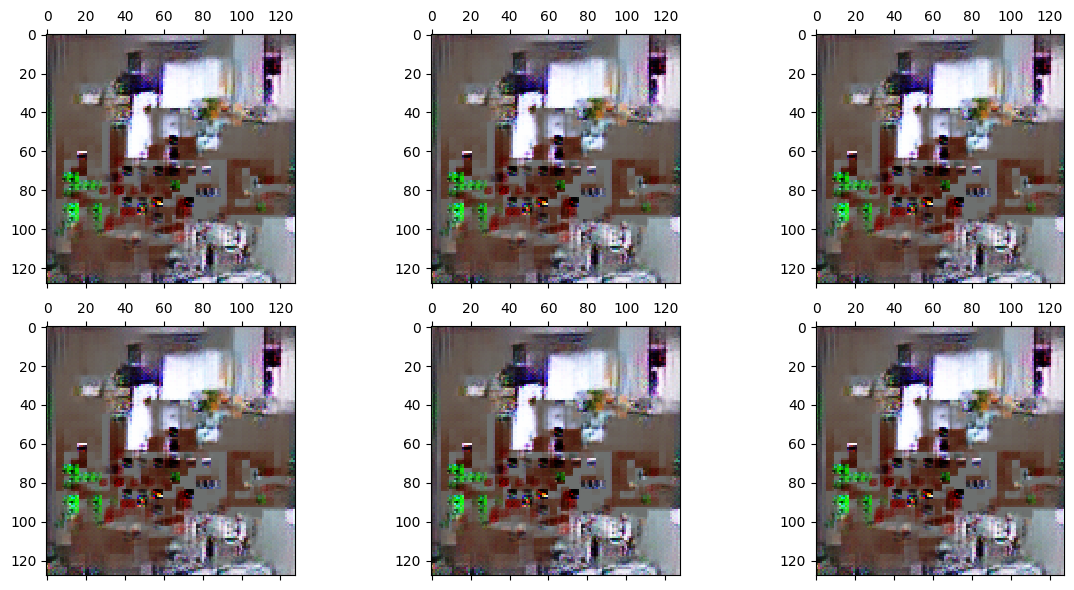

1/1 [==============================] - 0s 36ms/step
Current FiD score:  368.42472


In [ ]:
train_with_fid(gen_model, dis_model, gan_model, data, latent_dim)

In [ ]:
import numpy as np
import PIL.Image
import torch
import os
import re

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ffmpeg -i '/content/gdrive/MyDrive/Capstone Project/Model/DCGAN_Checkpoints/training_DCGAN_2/Backup/Performance_image_at_epoch_*.png' -r 24 -vcodec libx264 -pix_fmt yuv420p \
    '/content/gdrive/MyDrive/Capstone Project/Model/DCGAN_Checkpoints/training_DCGAN_2/DCGAN_Training.mp4'




ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [ ]:
import os
import imageio

png_dir = '/content/gdrive/MyDrive/Capstone Project/Model/DCGAN_Checkpoints/training_DCGAN_2/Backup'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave('/content/gdrive/MyDrive/Capstone Project/Model/DCGAN_Checkpoints/training_DCGAN_2/DCGAN_Training.gif', images,fps=55)

<ipython-input-8-3d82d7a07d97>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
<ipython-input-8-3d82d7a07d97>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


In [ ]:
import glob
from PIL import Image
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("/content/gdrive/MyDrive/Capstone Project/Model/DCGAN_Checkpoints/training_DCGAN_2/DCGAN_Training_1.gif", format="GIF", append_images=frames,
               save_all=True, duration=300, loop=0)

if __name__ == "__main__":
    make_gif("/content/gdrive/MyDrive/Capstone Project/Model/DCGAN_Checkpoints/training_DCGAN_2/Backup")